# 4. Application
This sheet can be run
Combines image model features and nlp features to provide recommend furniture

### 1. IMPORTS AND LIBRARIES

In [16]:
import numpy as np
import pandas as pd

from keras.applications import VGG16
import tables
import dill



# Libraries for displying the data. 
from IPython.core.display import HTML 
from ipywidgets import interact
from IPython.display import display
from IPython.display import Image

In [17]:
import itertools
from keras.models import Model
import keras
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [18]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

In [19]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

### 2. HELPER FUNCTIONS

In [20]:
size = 224
def get_input(img_path):
    img = imread(img_path)
    img = resize(img, (size, size,3), preserve_range=True).astype(np.float32)
    #img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [21]:
def get_predictions(img_path, model,decode=True):
    input_ = get_input(img_path)
    out = model.predict(input_)
    if decode:
        return decode_predictions(out)
    else:
        return out

### 3. LOAD IMAGE RECOMMENDER DATA

In [23]:
df_image = pd.read_csv('../data/model/recommender_matrix.csv') 
df_image = df_image.drop(columns = ['Unnamed: 0'])
print(df_image.shape)
df_image.head(2)

(35965, 132)


,image_link,product_name,page_link,label,ifeature1,ifeature2,ifeature3,ifeature4,ifeature5,ifeature6,...,ifeature119,ifeature120,ifeature121,ifeature122,ifeature123,ifeature124,ifeature125,ifeature126,ifeature127,ifeature128
0,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0.0,0.0,0.0,0.0,809.76886,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,645.9755
1,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0.0,0.0,0.0,0.0,606.45230,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513.0549


In [25]:
df_image['label'].value_counts()

coffee table    12543
sofa             9680
tv stand         7033
pouf             3402
armchair         3307
Name: label, dtype: int64

### 4. LOAD IMAGE MODEL 

In [30]:
my_model=models.load_model('../data/model/final_cnn_model.hdf5')

In [31]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [32]:
# I extract features from my second to last layer fc1 which has 128 neurons. 
#This performed better for the recommender  vis-a-vis using fc2 with 64 neurons
# set the following
layer_to_extract = 'fc1'
neurons = 128

In [33]:
my_model_extract = Model(inputs=my_model.input, outputs=my_model.get_layer(layer_to_extract).output)

### 5. LOAD NLP RECOMMENDER DATA

In [39]:
nlp_data = pd.read_csv('../data/model/nlp_matrix.csv')
nlp_data = nlp_data.drop(columns = 'Unnamed: 0')
print(nlp_data.shape)
nlp_data.head(2)

(35965, 11)


,image_link,product_name,page_link,label,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,-0.755367,-1.001257,-5.526652,-5.526095,-1.918496,-5.526696,-5.527224
1,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,-0.755367,-1.001257,-5.526652,-5.526095,-1.918496,-5.526696,-5.527224


In [40]:
# load nlp pipe line

In [41]:
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer

n_gram = 3
stem_type = 'snow' #change this to 'snow' or 'lemma' or 'porter'
snow = SnowballStemmer('english') # change stemmer here
wordnet_lemmatizer = WordNetLemmatizer()
vectorizer = dill.load(open('../data/model/nlp_tf_vectorizer', 'rb'))
lda_model = dill.load(open('../data/model/nlp_lda','rb'))

In [42]:
#text= 'glass metal modern silver steel coffee table'
text= 'rustic wood wooden distressed pine oak reclaimed coffee table natural'
#text ='leather armchair sofa dark deep color contemporary comfortable'
#text ='leather armchair sofa dark deep contemporary'
#text ='blue sofa linen cloth fabric modern'
#text = 'tv entertainment brown wood console'
#text ='orange bright pouf cube soft square round ottoman cicle'
#text ='Relax with a favorite book in this exquisite accent chair. Featuring birchwood legs and an elegantly pleated exterior, this chair offers superior comfort with high-density foam padding.'
#text =""

In [43]:
if(text!="" ):
    user_text = pd.DataFrame(columns=['excerpt'])
    user_text=user_text.append(pd.DataFrame([text], columns=['excerpt']),ignore_index=True)
    #print(user_text)
    vector = vectorizer.transform(user_text['excerpt'])
    #print("----",vector,"----")
    topic_vector = lda_model.transform(vector)
    #print(topic_vector)
    user_excerpt = pd.DataFrame(topic_vector, columns=['topic_'+ str(i)for i in range(1,8)])

In [44]:
user_excerpt

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,0.017884,0.017866,0.01789,0.892703,0.017877,0.017872,0.017909


In [45]:
user_excerpt=user_excerpt.apply(np.log)
user_excerpt

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,-4.023866,-4.024874,-4.023538,-0.113501,-4.024254,-4.024509,-4.022468


### 6. SIMILARITY FINDER IMAGE

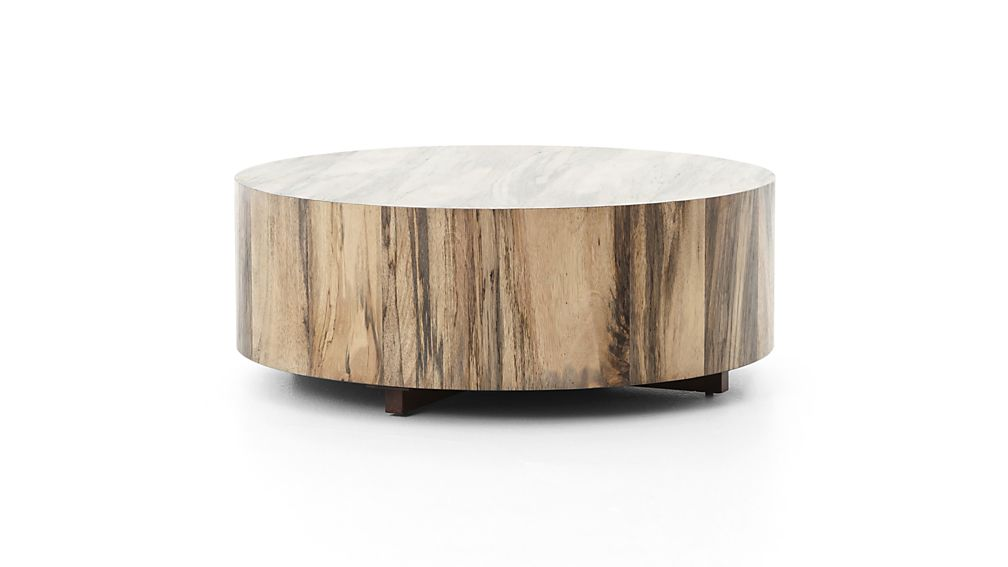

In [46]:
pic_link = '../data/samples/crate_barrel/crate_coffee_cirwood1.jpeg'
display(Image(filename=pic_link,width=300, height=300))

In [47]:
# matrices the input image
user_img_matrix=get_input(pic_link)
user_img_matrix = np.expand_dims(user_img_matrix, axis=0)
user_img_matrix.shape

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 224, 224, 3)

In [48]:
user_data = my_model_extract.predict(user_img_matrix)
search_in = np.array(df_image.loc[:,'ifeature1':]) 
print(user_data.shape)
print(search_in.shape)

(1, 128)
(35965, 128)


In [49]:
# similarity metrics

In [52]:
metric = 'euclid'
if(metric == 'euclid'):
    from sklearn.metrics.pairwise import euclidean_distances
    results= euclidean_distances(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=True).head(15)

if(metric == 'cosine'):    
    from sklearn.metrics.pairwise import cosine_similarity
    results = cosine_similarity(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=False).head(15)
    
if(metric == 'manhat'):    
    from sklearn.metrics.pairwise import manhattan_distances
    results = manhattan_distances(search_in, user_data)
    show_me_image = pd.DataFrame(results).sort_values(0, ascending=True).head(15)

show_me_image

,0
24993,321.049586
27438,340.146330
28865,363.759232
21042,369.118496
18407,369.501354
28678,371.631130
28855,384.138019
33597,395.593076
28857,415.785500
23924,415.849228


In [53]:
recommend_image = df_image.iloc[list(show_me_image.index),0:5].values
recommend_image.shape

(15, 5)

In [54]:
# recommendation based only on image similarity

for i in range(0,15):    
    display(Image(url=recommend_image[i][0],width=244, height=244))
    print('Link to page =',  recommend_image[i][2])

Link to page = https://www.overstock.com/Home-Garden/Emira-Reclaimed-Fir-Coffee-Table/23621916/product.html?refccid=22K53MB3ICX25SKEUTDG2I5HOA&searchidx=2041


Link to page = https://www.overstock.com/Home-Garden/TOR-C-Stool/23445737/product.html?refccid=EVQKEF5VT35LVYSM56MCKM5XBM&searchidx=2947


Link to page = https://www.overstock.com/Home-Garden/Handmade-Natural-Walnut-Oil-High-Brown-Cube-Thailand/10423220/product.html?refccid=Y5H56QT756U243SOHAZE4IED5Y&searchidx=3510


Link to page = https://www.overstock.com/Home-Garden/Best-Quality-Furniture-Mirrored-Crystal-2-Piece-Coffee-and-End-Table-Set/18550364/product.html?refccid=AAW6XMTZCLVKD32FLG3TAYMYQE&searchidx=903


Link to page = https://www.overstock.com/Home-Garden/East-At-Mains-Cummings-Blue-Coconut-Shell-Inlay-Round-Coffee-Table/13083782/product.html?refccid=OXKPCUIC5ETLVBCGGCVMDUXKQ4&searchidx=298


Link to page = https://www.overstock.com/Home-Garden/Safavieh-Tilly-Antique-Brass-Coffee-Table/14585182/product.html?refccid=RYVINZ3WCBLJH22KSNC4PHDNTM&searchidx=3448


Link to page = https://www.overstock.com/Home-Garden/Handmade-Haussmann-Agate-Grey-Oil-18-Inch-Cube-Coffee-Table-Thailand/11991352/product.html?refccid=Y5H56QT756U243SOHAZE4IED5Y&searchidx=3508


Link to page = https://www.overstock.com/Home-Garden/Seville-Classics-Faux-Leather-Quilted-Foldable-Storage-Ottoman-White/22162860/product.html?refccid=UDMZAR3LVGLLMOSJLTNG6Q2LBE&searchidx=177


Link to page = https://www.overstock.com/Home-Garden/Handmade-Haussmann-Agate-Grey-Oil-18-Inch-Cube-Coffee-Table-Thailand/11991352/product.html?refccid=Y5H56QT756U243SOHAZE4IED5Y&searchidx=3508


Link to page = https://www.overstock.com/Home-Garden/Wood-Rock-Coffee-Table/12044714/product.html?refccid=35JZL3DLPAMJ6I2GI46WWO4GX4&searchidx=1710


Link to page = https://www.overstock.com/Home-Garden/Renwil-Cooper-Coffee-Table/21030592/product.html?refccid=OBMVEVQV6WWKXBCFGAE4GHI3BQ&searchidx=1235


Link to page = https://www.overstock.com/Home-Garden/Pine-Canopy-Periwinkle-Rustic-Reclaimed-Pine-Round-Coffee-Table-with-Casters/21507908/product.html?refccid=FMRMZ33KZA62IVCNLETZJHE64E&searchidx=107


Link to page = https://www.overstock.com/Home-Garden/MJL-Furniture-Tami-Shakes-Square-Ikat-Storage-Ottoman/10544541/product.html?refccid=5J3A7VFHNYXKXT2CF7AVALDO4Y&searchidx=322


Link to page = https://www.overstock.com/Home-Garden/Handmade-Haussmann-Agate-Grey-Oil-18-Inch-Cube-Coffee-Table-Thailand/11991352/product.html?refccid=Y5H56QT756U243SOHAZE4IED5Y&searchidx=3508


Link to page = https://www.overstock.com/Home-Garden/Charlene-Coffee-Table/12044719/product.html?refccid=RYVINZ3WCBLJH22KSNC4PHDNTM&searchidx=3455


### 7. FILTER USING NLP SIMILARITY
take the top 15 images that are similar and sort them by text analysis similarity

In [31]:
if(text==""): # no text was given
    recommend_image = df_image.iloc[list(show_me_image.index),0:5].values
else:
    print('# shape em up to numpy arrays')
    given_excerpt = np.array(user_excerpt)
    print(nlp_data.iloc[list(show_me_image.index),4:])
    search_in = np.array(nlp_data.iloc[list(show_me_image.index),4:])
    from sklearn.metrics.pairwise import cosine_similarity
    results2 = cosine_similarity(search_in, given_excerpt)
    show_me_nlp = pd.DataFrame(results2).sort_values(0, ascending=False).head(10)
    print(show_me_nlp)
    final_list = list(show_me_image.iloc[list(show_me_nlp.index),:].index)
    print(final_list)
    recommend_image = df_image.iloc[final_list,0:10].values
    

# shape em up to numpy arrays
        topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7
29674 -5.311178 -0.557523 -5.310134 -5.311153 -0.909632 -5.309765 -5.309352
31525 -5.773231 -1.523806 -5.772914 -5.771928 -0.265845 -5.771342 -5.772778
31499 -5.773231 -1.523806 -5.772914 -5.771928 -0.265845 -5.771342 -5.772778
29558 -5.794822 -5.790939 -5.793942 -5.792723 -0.018463 -5.791472 -5.793839
30115 -5.240702 -5.237059 -5.240858 -5.240480 -0.032320 -5.240343 -5.240306
30288 -5.499911 -5.496193 -5.499196 -5.498681 -0.024871 -5.498293 -5.497139
31588 -5.439790 -5.437965 -5.440119 -5.439129 -0.109759 -2.498185 -5.438782
31060 -1.143092 -1.867888 -5.856321 -2.868460 -0.773636 -5.853319 -5.854267
32234 -1.986901 -2.403408 -5.968720 -5.968073 -0.271496 -5.967830 -5.969183
31681 -1.612662 -0.764942 -5.440163 -5.439295 -1.145940 -5.440209 -5.440346
32060 -5.078255 -0.843143 -5.079169 -5.079966 -0.618957 -5.078723 -5.077613
31061 -1.143092 -1.867888 -5.856321 -2.868460 -0.773636 -5

In [32]:
for i in range(0,10):    
    display(Image(url=recommend_image[i][0],width=244, height=244))
    print('Link to page =',  recommend_image[i][2])

Link to page = https://www.overstock.com/Home-Garden/CorLiving-Kelsey-Bonded-Leather-Modern-Recliner-Armchair/12853347/product.html?refccid=XXMJCI7TDDEKEGCG4U4NCDMJ5E&searchidx=57


Link to page = https://www.overstock.com/Home-Garden/ALEXANDRIA-ARMCHAIR-GIOTTO-GREY-FABRIC/13001004/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=459


Link to page = https://www.overstock.com/Home-Garden/Delta-Children-Epic-Upholstered-Glider/10545285/product.html?refccid=YXGQT5WU7OH3KY2KWKNOTIEXLU&searchidx=75


Link to page = https://www.overstock.com/Home-Garden/Classic-Linen-Armchair-Living-Room-Accent-Chair/17668770/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=343


Link to page = https://www.overstock.com/Home-Garden/Classic-Linen-Armchair-Living-Room-Accent-Chair/17668770/product.html?refccid=O6YEU3LR5EHKNXSPCNT4IBT2GI&searchidx=343


Link to page = https://www.overstock.com/Home-Garden/Aristocrat-Accent-Armchair/19569357/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=444


Link to page = https://www.overstock.com/Home-Garden/Aristocrat-Accent-Armchair/19569357/product.html?refccid=VK4BJ2M5EJYICASCJP5H7Z6HEY&searchidx=444


Link to page = https://www.overstock.com/Home-Garden/Katalina-Chair/20179954/product.html?refccid=5JO5WDPKCAFLDESAWOZ2I4REU4&searchidx=368


Link to page = https://www.overstock.com/Home-Garden/Modern-Living-Room-Accent-Arm-Chair-in-Faux-Leather/17793383/product.html?refccid=IMMXQGKOCKUYERCKNXN3RMAC7U&searchidx=499


Link to page = https://www.overstock.com/Home-Garden/Modern-Living-Room-Accent-Arm-Chair-in-Faux-Leather/17793383/product.html?refccid=IMMXQGKOCKUYERCKNXN3RMAC7U&searchidx=499
